The main purpose of an LSTM network is to process and analyze sequences of data, so it should perform quite well on stock market. Obviously predicting Stock Market is close to impossible. There are many, many different factors which determine price and move of the stock, and we can't follow them all. Fluctuation of the market is an inseparable element. But still - Stock Market - especially past data - is great source of datasets which we can you to practice new things.

### LSTM

LSTMs are a type of recurrent neural network (RNN) that are designed to better handle long-term dependencies in sequential data. The memory cell is controlled by three gates: the input gate, the forget gate, and the output gate. The input gate decides which values to update in the cell based on the current input, the forget gate decides which values to keep or discard from the previous cell state based on the current input, and the output gate decides which values from the current cell state to output. LSTMs are able to learn complex patterns in sequential data because they can selectively remember or forget information from previous inputs and states.

# TO DO
* Hyperparameter tuning
* Add better comments
* Test on totally new dataset
* Delete zeros from plots legend
* Check whether our model overfit(looking at results, probably yes)

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn

from sklearn.preprocessing import MinMaxScaler

sns.set_style("darkgrid", {"axes.facecolor": ".9"})
sns.set_palette('flare')
#plt.style.use('dark_background')

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


**As a first step, we will read data, parse dates, and preprocess columns. Scaling is quite important - networks perform much better on scaled sets. We have to - also - split our data.**

In [2]:
# Preprocessing (Spliting our data and scaling)
def preprocessing(data):
    l = int(data.shape[0] * 0.8)
    train_data, test_data = data.iloc[:l,:], data.iloc[l:,:]

    scaler = MinMaxScaler()
    train_data = scaler.fit_transform(train_data)
    test_data = scaler.transform(test_data)
    
    return train_data, test_data, scaler

# Essential function for LSMT. We generate Xs - some past records Ys - Values which will be prediced
# using the Xs.
def create_sequences(data, seq_length):
    X = []
    y = []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return X, y

def plotter(y_pred, y_test):
    fig, axes = plt.subplots(4,1, figsize=(13,12))
    labels = {0:'Open Price',1:'Close Price',2:'Highest Price', 3:'Lowest Price'}
    
    for i in range(4):
        sns.lineplot(y_test.numpy()[:,i].reshape(-1,1), ax=axes[i], palette=['green'], label='TEST')
        sns.lineplot(y_pred.numpy()[:,i].reshape(-1,1), ax=axes[i], palette=['orange'], label='PREDICTED')
        axes[i].set_ylabel(f'{labels[i]}')  
    
    plt.show()

# Fitting model to our data
def fit(model, num_epochs, criterion, optimizer, X_train, y_train):
    for epoch in range(num_epochs):
        
        outputs = model(X_train) # forward function
        loss = criterion(outputs, y_train) # loss calculation 
        optimizer.zero_grad() # Gradient reset
        loss.backward() # Backward prop
        optimizer.step() # Weight update

        if (epoch+1) % 10 == 0:
            print(f'Epoch: {epoch+1}/{num_epochs}, Loss: {loss.item()}')
    return model

# Predicting on our data
def predict(model, X):
    with torch.no_grad():
        model.eval()
        return model(X_test)

# LSTM Model
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(LSTMModel,self).__init__()
        self.hidden_size = hidden_size
        self.lstm1 = nn.LSTM(input_size, hidden_size)
        self.lstm2 = nn.LSTM(hidden_size, hidden_size)
        self.fc = nn.Linear(hidden_size, output_size)
        
    def forward(self, x):
        lstm_out1, _ = self.lstm1(x)
        lstm_out2, _ = self.lstm2(lstm_out1)
        output = self.fc(lstm_out2[:, -1, :])
        return output

In [3]:
# Reading data, selection proper columns, converting date
dataset = pd.read_csv('/kaggle/input/netflix-stock-price-data-set-20022022/NFLX.csv',parse_dates=['Date'], index_col=0)
data = dataset[['Open','Close','High','Low']]

# some params
seq_length = 5 #length of sequence

# Preprocessing
train_data, test_data, scaler = preprocessing(data)

# Creating sequences
X_train, y_train = create_sequences(train_data, seq_length)
X_test, y_test = create_sequences(test_data, seq_length)

# Shapes
display(np.array(X_train).shape)
display(np.array(X_test).shape)

# Converting our sequences into sensors. It is required by PyTorch
X_train = torch.tensor(X_train).float()
y_train = torch.tensor(y_train).float()
X_test = torch.tensor(X_test).float()
y_test = torch.tensor(y_test).float()

(4030, 5, 4)

(1004, 5, 4)

/tmp/ipykernel_20/1049201296.py:20: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:245.)
  X_train = torch.tensor(X_train).float()


##### We created 3D sequences of data. LSTM requires (Batch size, Sequence Length, Feature Dimension). Now we can start to build our model using PyTorch!

Epoch: 10/100, Loss: 0.02051503211259842
Epoch: 20/100, Loss: 0.0026477312203496695
Epoch: 30/100, Loss: 0.0006715167546644807
Epoch: 40/100, Loss: 0.00018674618331715465
Epoch: 50/100, Loss: 0.00012076035636710003
Epoch: 60/100, Loss: 7.96400272520259e-05
Epoch: 70/100, Loss: 6.59974102745764e-05
Epoch: 80/100, Loss: 5.998619963065721e-05
Epoch: 90/100, Loss: 5.5754182540113106e-05
Epoch: 100/100, Loss: 5.292581772664562e-05


tensor(0.0249)

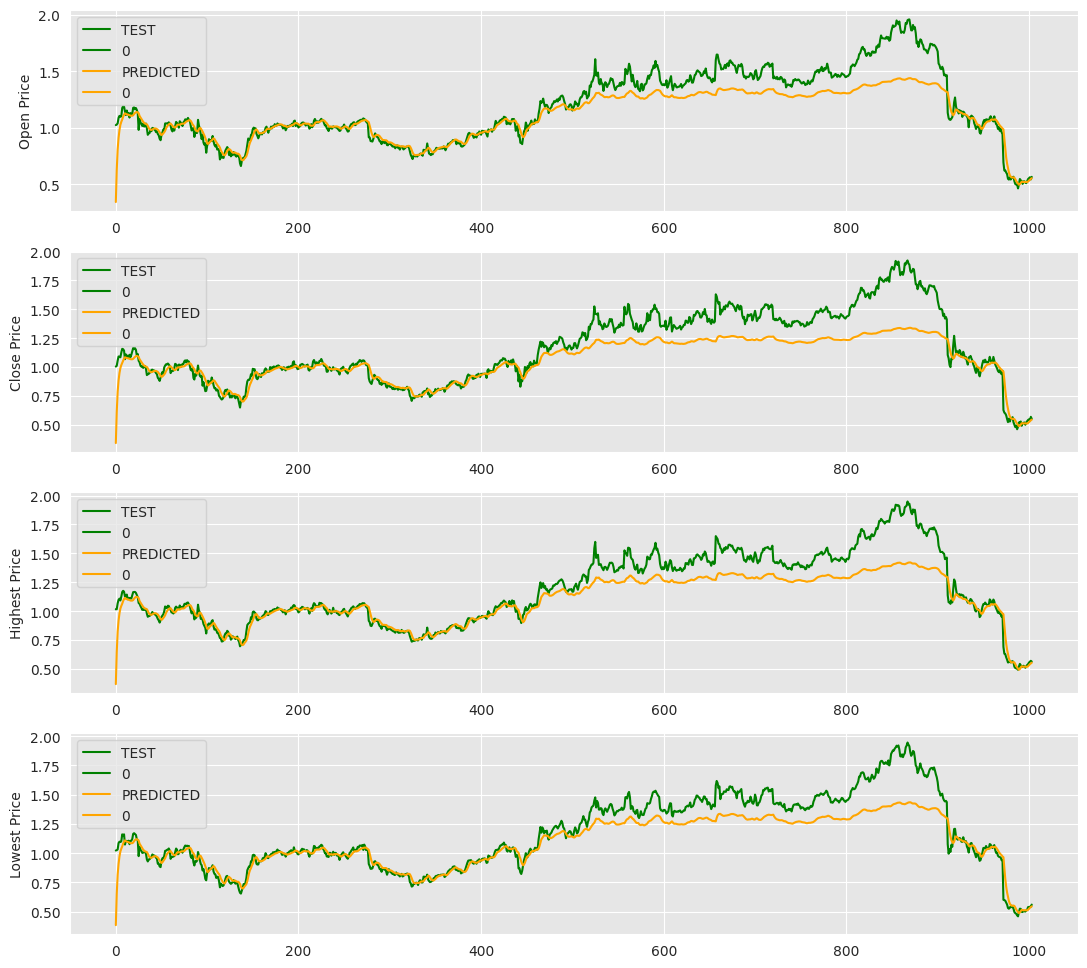

In [4]:
# some params
input_size = X_train.shape[2]
hidden_size = 128
output_size = 4
learning_rate = 0.01
num_epochs = 100

model = LSTMModel(input_size, hidden_size, output_size)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Fit to train_data
model = fit(model, num_epochs, criterion, optimizer, X_train, y_train)

# Predicting on test_data
y_pred = predict(model, X_test)
display(criterion(y_pred, y_test))

# Plot    
plotter(y_pred, y_test)

**As we can observe, our model has shown good performance. However, it is important to note that predicting the stock market is a challenging task, and making financial decisions solely based on model predictions is not advisable. Nevertheless, LSTM, as a powerful sequential model, has proven to be a valuable tool in analyzing time-series data, such as stock prices. Understanding and utilizing LSTM can be beneficial for various applications beyond stock market prediction. It is a model worth exploring and incorporating into one's toolkit for data analysis and forecasting tasks involving sequential data.**


